In [1]:
# change into root directory to the project
import os
os.chdir('..')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy 

import glob

from neurolib.models.aln import ALNModel

import neurolib.utils.loadData as ld
import neurolib.utils.functions as func
import neurolib.utils.fitparams as fp

# sett dpi for notebooks on server
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['image.cmap'] = 'plasma'

# Single node simulation

In [7]:
alnModel = ALNModel()
alnModel.params['duration'] = 20.0*1000
alnModel.params['sigma_ou'] = 0.1 # add some noise

alnModel.run()

(0, 2000)

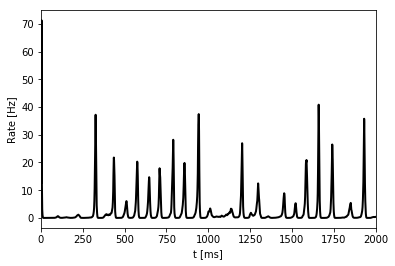

In [9]:
plt.plot(alnModel.t, alnModel.rates_exc.T, lw=2, c='k')
# alternatively, you can access the results in an xarray
#plt.plot(alnModel.xr[0, 0].time, alnModel.xr[0, 0].values)
plt.xlabel("t [ms]")
plt.ylabel("Rate [Hz]")
plt.xlim(0, 2000)

## BOLD model

In [10]:
# This block demonstrates how the BOLDModel class is interfaced 
# This is also builtin into ALNModel, as demonstrated later

In [11]:
from neurolib.models import bold

In [12]:
boldModel = bold.BOLDModel(alnModel.params['N'], alnModel.params['dt'])

In [13]:
boldModel.run(alnModel.rates_exc)

Text(0, 0.5, 'BOLD activity')

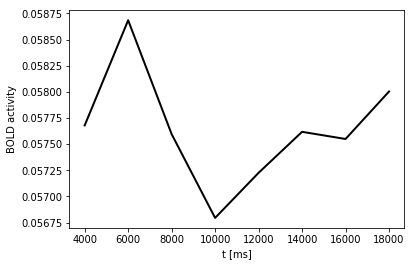

In [14]:
plt.plot(boldModel.t_BOLD[2:], boldModel.BOLD[:,2:].T, lw=2, c='k')
plt.xlabel("t [ms]")
plt.ylabel("BOLD activity")

# Whole brain model

## Load data

In [15]:
from neurolib.utils.loadData import Dataset

ds = Dataset("gw")

In [16]:
alnModel = ALNModel(Cmat = ds.Cmat, Dmat = ds.Dmat, simulateBOLD=True) # simulates the whole-brain model in 10s chunks by default if simulateBOLD == True

In [17]:
# Resting state fits
load_set = 1
if load_set == 0:
    parnames = ['mue_ext_mean', 'mui_ext_mean', 'sigma_ou', 'a', 'b']
    parvals =  [1.414,  1.523,  0.1028, 0.0, 5.0]
    for p, v in zip(parnames, parvals):
        alnModel.params[p] = v
elif load_set == 1:
    parnames = ['mue_ext_mean', 'mui_ext_mean', 'sigma_ou', 'a', 'b']
    parvals =  [1.572627,  1.598011,  0.093930, 0.0, 5.0]
    for p, v in zip(parnames, parvals):
        alnModel.params[p] = v        

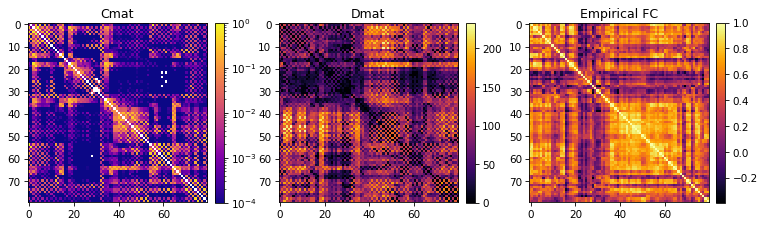

In [18]:
# Plotting data
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1, 3, figsize=(12,8), dpi=75)
fig.subplots_adjust(wspace=0.28)

im = axs[0].imshow(alnModel.params['Cmat'], norm=LogNorm(vmin=10e-5, vmax=np.max(alnModel.params['Cmat'])))
axs[0].set_title("Cmat")
fig.colorbar(im, ax=axs[0],fraction=0.046, pad=0.04)
im = axs[1].imshow(alnModel.params['lengthMat'], cmap='inferno')
axs[1].set_title("Dmat")
fig.colorbar(im, ax=axs[1],fraction=0.046, pad=0.04)
im = axs[2].imshow(ds.FCs[0], cmap='inferno')
axs[2].set_title("Empirical FC")
fig.colorbar(im, ax=axs[2],fraction=0.046, pad=0.04)

## Run model

In [34]:
alnModel.params['duration'] = 5*60*1000 # ms

alnModel.run()

## Results

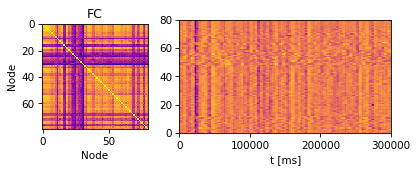

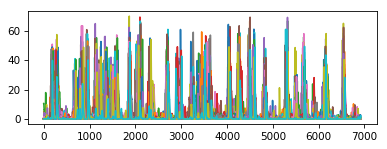

In [36]:
# Plot functional connectivity and BOLD timeseries (z-scored)
fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=75, gridspec_kw={'width_ratios' : [1, 2]})
axs[0].imshow(func.fc(alnModel.BOLD[:, 5:]))
axs[1].imshow(scipy.stats.mstats.zscore(alnModel.BOLD[:, 5:], axis=1), aspect='auto', extent=[0, alnModel.t_BOLD[-1], 0, alnModel.params['N']]);

axs[0].set_title("FC")
axs[0].set_xlabel("Node")
axs[0].set_ylabel("Node")

axs[1].set_xlabel("t [ms]")

# the results of the model are also accesible through an xarray!
fig, axs = plt.subplots(1, 1, figsize=(6, 2), dpi=75)
plt.plot(alnModel.xr.loc['rates_exc'].time, alnModel.xr.loc['rates_exc'].T);

In [37]:
scores = []
for i in range(len(ds.FCs)):
    fc_score = func.matrix_correlation(func.fc(alnModel.BOLD[:, 5:]), ds.FCs[i])
    scores.append(fc_score)
    print("Subject {}: {:.2f}". format(i, fc_score))
print("Mean FC/FC correlation: {:.2f}".format(np.mean(scores)))

Subject 0: 0.69
Subject 1: 0.69
Subject 2: 0.53
Subject 3: 0.53
Subject 4: 0.49
Subject 5: 0.59
Subject 6: 0.62
Subject 7: 0.61
Subject 8: 0.33
Subject 9: 0.54
Subject 10: 0.47
Mean FC/FC correlation: 0.55
